 # Breakdown of the total sale value per item per month

In [1]:
import json
import pandas as pd
import numpy as np
import re

with open("transaction-data-adhoc-analysis.json","r") as f:
    tdata = json.load(f)
    
df = pd.DataFrame(tdata)
df.drop(["address","birthdate","mail","sex"], axis=1, inplace=True)

### Unit Price 

In [2]:
# split orders per customer
df1=df['transaction_items'].str.split(';',expand=True)

# extract customers with only 1 order
df2 = df1[df1.count(axis=1)==1][0].str.split(',',expand=True)
df2['quantity'] = (df2[2].apply(lambda x: re.search(r'\d+', x).group())).astype(int)

# extract customer orders with only 1 quantity
df3 = pd.merge(df, df2[df2['quantity']==1], left_index=True, right_index=True)

# remove duplicates, retain only one item to get price
df4 = df3.drop_duplicates(subset = [1])
df4 = df4.sort_values(1, ascending=True)

# final unit price table
df5 = df4.loc[:,[1,0,'transaction_value']].reset_index(drop=True)
df5.columns = ['item', 'brand', 'unit price']
df6 = df5.set_index('item')
df6

,brand,unit price
item,,
Beef Chicharon,Exotic Extras,1299
Gummy Vitamins,HealthyKid 3+,1500
Gummy Worms,Candy City,150
Kimchi and Seaweed,Exotic Extras,799
Nutrional Milk,HealthyKid 3+,1990
Orange Beans,Candy City,199
Yummy Vegetables,HealthyKid 3+,500


In [3]:
df1

,0,1,2
0,"Exotic Extras,Beef Chicharon,(x4)",None,None
1,"Exotic Extras,Beef Chicharon,(x3)","HealthyKid 3+,Nutrional Milk,(x4)","Candy City,Orange Beans,(x1)"
2,"HealthyKid 3+,Gummy Vitamins,(x3)","HealthyKid 3+,Yummy Vegetables,(x2)",None
3,"HealthyKid 3+,Yummy Vegetables,(x1)",None,None
4,"Candy City,Orange Beans,(x3)","Candy City,Gummy Worms,(x4)","HealthyKid 3+,Gummy Vitamins,(x1)"
...,...,...,...
83031,"Exotic Extras,Kimchi and Seaweed,(x2)","HealthyKid 3+,Nutrional Milk,(x1)",None
83032,"HealthyKid 3+,Yummy Vegetables,(x1)","Exotic Extras,Kimchi and Seaweed,(x1)","Candy City,Orange Beans,(x4)"
83033,"Candy City,Orange Beans,(x4)","Candy City,Gummy Worms,(x4)","HealthyKid 3+,Yummy Vegetables,(x4)"
83034,"HealthyKid 3+,Nutrional Milk,(x2)","Candy City,Gummy Worms,(x2)",None


###  Total sale value breakdown per month

Item Breakdown Table Reference[2]

In [4]:
# split rows
lst_col = 'transaction_items' 
x = df.assign(**{lst_col:df[lst_col].str.split(';')}) 
tdf = pd.DataFrame(
    {col:np.repeat(x[col].values, x[lst_col].str.len())
     for col in x.columns.difference([lst_col])
    }).assign(**{lst_col:np.concatenate(x[lst_col].values)})[x.columns.tolist()]  #Source: wjandrea https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows

# convert transaction_date strings into datetime
tdf['transaction_date'] = pd.to_datetime(tdf['transaction_date'])
tdf['month'] = tdf['transaction_date'].dt.month_name()

# custom number of splits
brand_split = tdf['transaction_items'].str.split(',', n=3, expand=True)
brand_split.rename(columns={0: 'brand', 1: 'item', 2:'qty'}, inplace=True)
brand_split['quantity'] = (brand_split['qty'].apply(lambda x: re.search(r'\d+', x).group())).astype(int) 
new_df = pd.concat([tdf,brand_split],axis=1, ignore_index=False)

sorted_months = new_df.month.unique()
new_df['month'] = pd.Categorical(new_df['month'], categories=sorted_months, ordered=True)

#### __Items Sold Breakdown Table__

In [5]:
# pivot table
dfc = new_df.pivot_table(index=["item"],columns="month",aggfunc={'quantity': 'sum'}).sort_index()
dfd = dfc["quantity"]

# converts column names into strings
dfd.columns = map(str, dfd.columns)
dfd

,January,February,March,April,May,June
item,,,,,,
Beef Chicharon,9665,10001,9816,9890,10028,9902
Gummy Vitamins,9681,9980,10145,9842,9948,9980
Gummy Worms,9559,9996,9986,10043,9801,9934
Kimchi and Seaweed,9676,9949,9967,9921,9773,10104
Nutrional Milk,9727,9691,9876,9786,9881,9767
Orange Beans,9774,10037,9611,9914,9964,10106
Yummy Vegetables,9959,10256,9896,9861,9735,9722


#### __Merged Unit Price and Items Sold Table__

In [6]:
# Merge unit_price table and items_sold table

extracted_col = df6[["unit price"]]
dfd.insert(0, "unit price", extracted_col)
dfe = dfd.copy()
dfe

,unit price,January,February,March,April,May,June
item,,,,,,,
Beef Chicharon,1299,9665,10001,9816,9890,10028,9902
Gummy Vitamins,1500,9681,9980,10145,9842,9948,9980
Gummy Worms,150,9559,9996,9986,10043,9801,9934
Kimchi and Seaweed,799,9676,9949,9967,9921,9773,10104
Nutrional Milk,1990,9727,9691,9876,9786,9881,9767
Orange Beans,199,9774,10037,9611,9914,9964,10106
Yummy Vegetables,500,9959,10256,9896,9861,9735,9722


#### __Sales Breakdown Table__

In [7]:
# Multiply unit_price column to each items_sold_per_month columns
dfe["January (SALES)"] = dfe["unit price"] * dfe["January"]
dfe["February (SALES)"] = dfe["unit price"] * dfe["February"]
dfe["March (SALES)"] = dfe["unit price"] * dfe["March"]
dfe["April (SALES)"] = dfe["unit price"] * dfe["April"]
dfe["May (SALES)"] = dfe["unit price"] * dfe["May"]
dfe["June (SALES)"] = dfe["unit price"] * dfe["June"]

In [8]:
dfe

,unit price,January,February,March,April,May,June,January (SALES),February (SALES),March (SALES),April (SALES),May (SALES),June (SALES)
item,,,,,,,,,,,,,
Beef Chicharon,1299,9665,10001,9816,9890,10028,9902,12554835,12991299,12750984,12847110,13026372,12862698
Gummy Vitamins,1500,9681,9980,10145,9842,9948,9980,14521500,14970000,15217500,14763000,14922000,14970000
Gummy Worms,150,9559,9996,9986,10043,9801,9934,1433850,1499400,1497900,1506450,1470150,1490100
Kimchi and Seaweed,799,9676,9949,9967,9921,9773,10104,7731124,7949251,7963633,7926879,7808627,8073096
Nutrional Milk,1990,9727,9691,9876,9786,9881,9767,19356730,19285090,19653240,19474140,19663190,19436330
Orange Beans,199,9774,10037,9611,9914,9964,10106,1945026,1997363,1912589,1972886,1982836,2011094
Yummy Vegetables,500,9959,10256,9896,9861,9735,9722,4979500,5128000,4948000,4930500,4867500,4861000


In [9]:
sales_df = dfe[["January (SALES)","February (SALES)","March (SALES)","April (SALES)","May (SALES)","June (SALES)"]].copy()
sales_df

,January (SALES),February (SALES),March (SALES),April (SALES),May (SALES),June (SALES)
item,,,,,,
Beef Chicharon,12554835,12991299,12750984,12847110,13026372,12862698
Gummy Vitamins,14521500,14970000,15217500,14763000,14922000,14970000
Gummy Worms,1433850,1499400,1497900,1506450,1470150,1490100
Kimchi and Seaweed,7731124,7949251,7963633,7926879,7808627,8073096
Nutrional Milk,19356730,19285090,19653240,19474140,19663190,19436330
Orange Beans,1945026,1997363,1912589,1972886,1982836,2011094
Yummy Vegetables,4979500,5128000,4948000,4930500,4867500,4861000


## Analysis

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

#### Charts per item

<function matplotlib.pyplot.show(close=None, block=None)>

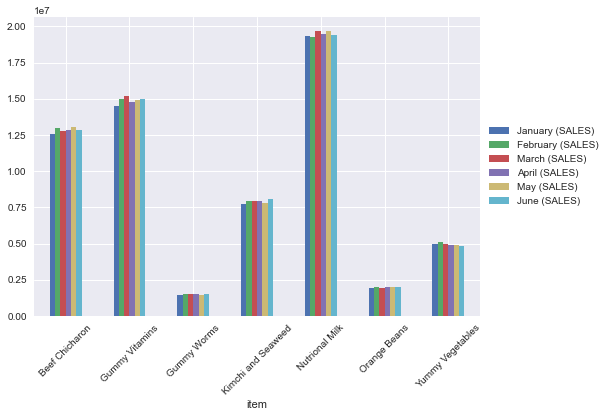

In [11]:
sales_df.plot(y=["January (SALES)", "February (SALES)", "March (SALES)", "April (SALES)", "May (SALES)", "June (SALES)"], kind="bar",rot=45)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # https://stackoverflow.com/questions/23556153/how-to-put-legend-outside-the-plot-with-pandas
plt.show

__Beef Chicharon__

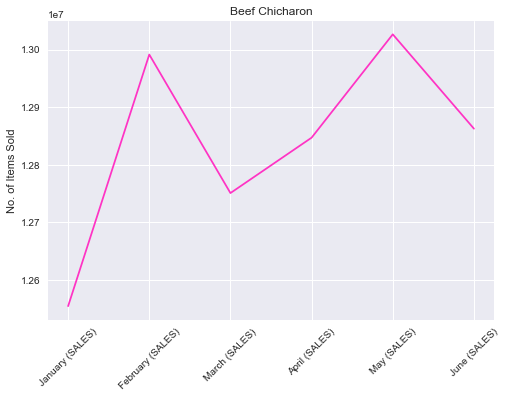

In [31]:
row = sales_df.iloc[0]
row.plot(kind='l', rot=45, color='#FF33C4')
plt.ylabel("No. of Items Sold")
plt.title("Beef Chicharon")
plt.show()

__Gummy Vitamins__

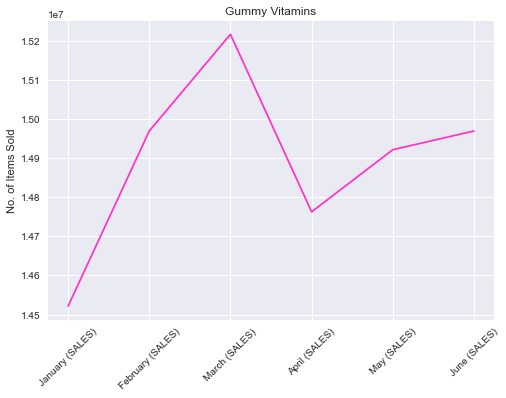

In [13]:
row = sales_df.iloc[1]
row.plot(kind='line', rot=45, color='#FF33C4')
plt.ylabel("No. of Items Sold")
plt.title("Gummy Vitamins")
plt.show()

__Gummy Worms__

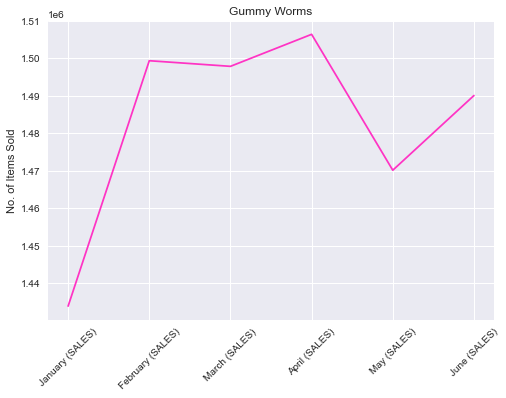

In [14]:
row = sales_df.iloc[2]
row.plot(kind='line', rot=45, color='#FF33C4')
plt.ylabel("No. of Items Sold")
plt.title("Gummy Worms")
plt.show()

__Kimchi and Seaweed__

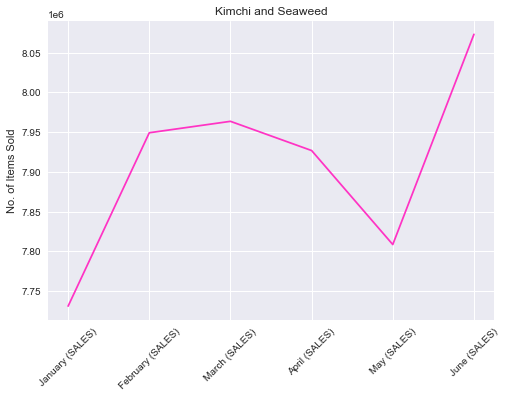

In [15]:
row = sales_df.iloc[3]
row.plot(kind='line', rot=45, color='#FF33C4')
plt.ylabel("No. of Items Sold")
plt.title("Kimchi and Seaweed")
plt.show()

__Nutrional Milk__

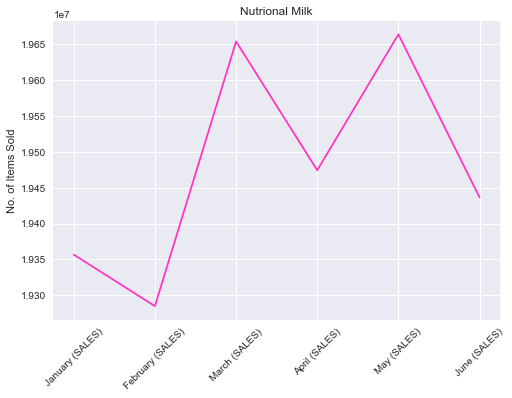

In [16]:
row = sales_df.iloc[4]
row.plot(kind='line', rot=45, color='#FF33C4')
plt.ylabel("No. of Items Sold")
plt.title("Nutrional Milk")
plt.show()

__Orange Beans__

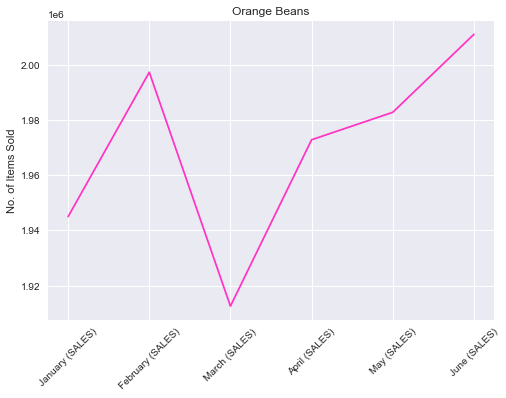

In [17]:
row = sales_df.iloc[5]
row.plot(kind='line', rot=45, color='#FF33C4')
plt.ylabel("No. of Items Sold")
plt.title("Orange Beans")
plt.show()

__Yummy Vegetables__

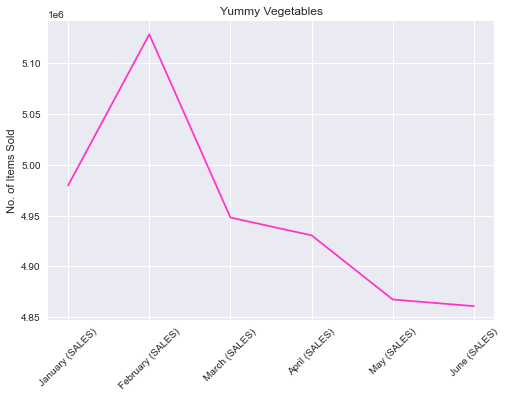

In [18]:
row = sales_df.iloc[6]
row.plot(kind='line', rot=45, color='#FF33C4')
plt.ylabel("No. of Items Sold")
plt.title("Yummy Vegetables")
plt.show()